In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [23]:
config_path = "src/app_dtd_config.json"
import json
with open(config_path) as f:
    config = json.load(f)
config

{'us_state': 'va',
 'general_population_path': '/project/bii_nssac/production/detailed_populations/ver_2_4_0/',
 'population_path': '/project/bii_nssac/production/detailed_populations/ver_2_4_0/va'}

In [ ]:
## Population data 
pop_path = "/project/bii_nssac/production/detailed_populations/ver_2_4_0/"
pop_dir = f"{pop_path}{config['us_state']}"


##  Load individual files for merging

#### person and households
person = pd.read_csv(pop_dir+"/base_population/va_person.csv")
hhold = pd.read_csv(pop_dir+"/base_population/va_household.csv")

## Home location data
home_loc = pd.read_csv(pop_dir+"/home_location_assignment/va_household_residence_assignment.csv")


In [13]:
pop = person.merge(home_loc[['hid','blockgroup_id']])
pop.head()

,hid,pid,serialno,person_number,record_type,age,relationship,sex,school_enrollment,grade_level_attending,employment_status,occupation_socp,race,hispanic,designation,blockgroup_id
0,159646428,361190001,2015001115132,1,P,50,0,1,1.0,NaN,6.0,NaN,1,1,none,510010901001
1,159646428,361190002,2015001115132,2,P,77,6,2,1.0,NaN,6.0,NaN,1,1,none,510010901001
2,159646429,361190003,2015000916108,1,P,24,0,2,1.0,NaN,6.0,412010,1,1,retail,510010901001
3,159646429,361190004,2015000916108,2,P,27,1,1,1.0,NaN,1.0,519111,1,1,none,510010901001
4,159646429,361190005,2015000916108,3,P,6,2,1,2.0,3.0,NaN,NaN,1,1,none,510010901001


In [ ]:
# Mapping synth pop characteristics to similar values as surveillance data columns

### County
pop['patient_county'] = pop["blockgroup_id"].astype(str).str.slice(0,5).astype(int)
#pop.county.value_counts()

### Sex
#sex_mapping = {1:"Male",2:"Female"}
sex_mapping = {1:"M",2:"F"}
pop['patient_current_sex'] = pop['sex'].map(sex_mapping)

### Age Groups

age_group_mapping = {0:'0-9 Years', 1:'10-19 Years',2:'20-29 Years',
                     3:'30-39 Years',4:'40-49 Years',5:'50-59 Years',
                     6:'60-69 Years',7:'70-79 Years',
                     8:'80+  Years',9:'80+  Years',10:'80+  Years'}
pop['ag'] = pop.age /10
pop['ag'] = pop.ag.apply(np.floor)
pop['age_group'] = pop['ag'].map(age_group_mapping)

### Race
full_race_mapping = {1:'White',2:'Black',3: 'American Indian alone',4: 'Alaska Native alone',
                     5:'American Indian and Alaska Native tribes', 6: 'Asian alone',
                     7:'Native Hawaiian and Other Pacific Islander alone',
                     8:'Some Other Race alone', 9: 'Two or More Races'}
tier_race_mapping = {1:'White',2:'Black',3: 'Native American',4: 'Native American',
                     5:'Native American', 6: 'Asian or Pacific Islander',
                     7:'Asian or Pacific Islander',
                     8:'Other Race', 9: 'Two or more races'}

pop['tiered_race_ethnicity'] = pop['race'].map(tier_race_mapping)

## Override race with Latino  for all Hispanic Ethnicities
pop.loc[pop.hispanic>1,'tiered_race_ethnicity'] = 'Latino'

In [15]:
pop[pop.hispanic>1]['tiered_race_ethnicity'].value_counts()

tiered_race_ethnicity
Latino    638878
Name: count, dtype: int64

In [16]:
###  Dump the aligned synthetic population
pop.to_csv("va_person_genomic_surveillance_fields.csv")

In [ ]:
# 1	White alone	2301390	62.767213
# 2	Black or African American alone	865171	23.596336
# 3	American Indian alone	6234	0.170024
# 4	Alaska Native alone	274	0.007473
# 5	American Indian and Alaska Native tribes	2516	0.068620
# 6	Asian alone	257694	7.028246
# 7	Native Hawaiian and Other Pacific Islander alone	2098	0.057220
# 8	Some Other Race alone	88380	2.410442
# 9	Two or More Races	142791	3.894426

### Make the look up list for the surveillance columns

In [17]:
identifying_columns = ['patient_county','patient_current_sex','age_group','tiered_race_ethnicity']
group_counts = pop.groupby(identifying_columns)['pid'].count().reset_index()
group_counts.columns = identifying_columns+['subpop_size']
group_counts.sample(5)

,patient_county,patient_current_sex,age_group,tiered_race_ethnicity,subpop_size
12318,51800,M,50-59 Years,White,3396
9399,51540,M,50-59 Years,Black,469
5399,51115,M,40-49 Years,Latino,3
2216,51047,M,30-39 Years,White,1811
6574,51145,F,30-39 Years,Asian or Pacific Islander,12


In [18]:
### Export tables to HTML with nice formatting

def create_styled_html(df, title, filename=None):
    """
    Convert a DataFrame to nicely styled HTML
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe to style
    title : str
        Title for the table
    filename : str, optional
        If provided, saves HTML to this file
    
    Returns:
    --------
    str : HTML string
    """
    
    # Create styled dataframe
    styled = df.style.set_table_attributes('class="dataframe"').set_caption(title)
    
    # Add custom CSS
    css = """
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            padding: 20px;
            background-color: #f5f5f5;
        }
        .dataframe {
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
            background-color: white;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .dataframe th {
            background-color: #4CAF50;
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: bold;
            border-bottom: 2px solid #45a049;
        }
        .dataframe td {
            padding: 10px;
            border-bottom: 1px solid #ddd;
        }
        .dataframe tr:hover {
            background-color: #f5f5f5;
        }
        .dataframe tr:nth-child(even) {
            background-color: #f9f9f9;
        }
        caption {
            font-size: 1.5em;
            font-weight: bold;
            margin: 10px 0;
            color: #333;
            text-align: left;
        }
    </style>
    """
    
    # Generate HTML
    html_string = styled.to_html()
    full_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>{title}</title>
        {css}
    </head>
    <body>
        {html_string}
    </body>
    </html>
    """
    
    # Save to file if filename provided
    if filename:
        with open(filename, 'w') as f:
            f.write(full_html)
        print(f"HTML saved to: {filename}")
    
    return full_html

# Example: Export group_counts summary
html_output = create_styled_html(
    group_counts.head(20), 
    "Sub-Population Sizes by Demographic Groups",
    "subpop_sizes_summary.html"
)

# Display in notebook (if using Jupyter)
from IPython.display import HTML
HTML(html_output)

HTML saved to: subpop_sizes_summary.html


,patient_county,patient_current_sex,age_group,tiered_race_ethnicity,subpop_size
0,51001,F,0-9 Years,Asian or Pacific Islander,7
1,51001,F,0-9 Years,Black,387
2,51001,F,0-9 Years,Latino,200
3,51001,F,0-9 Years,Other Race,8
4,51001,F,0-9 Years,Two or more races,76
5,51001,F,0-9 Years,White,870
6,51001,F,10-19 Years,Asian or Pacific Islander,10
7,51001,F,10-19 Years,Black,459
8,51001,F,10-19 Years,Latino,176
9,51001,F,10-19 Years,Other Race,5


In [19]:
pwd


'/sfs/gpfs/tardis/home/bl4zc'

In [14]:
## Merge in group sizes of identifying columns
surv_with_sizes = va_gen.merge(group_counts,on=identifying_columns,how='left')
print(va_gen.shape,surv_with_sizes.shape)

(97860, 45) (97860, 46)


<Axes: >

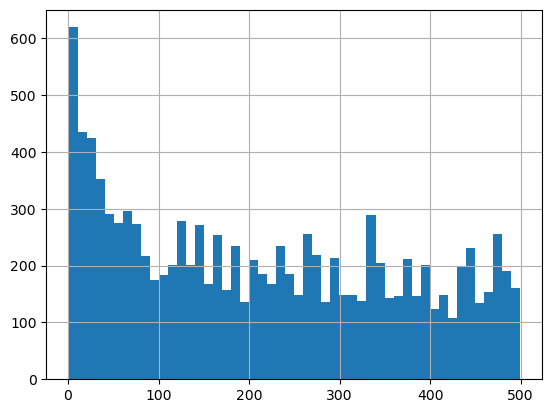

In [15]:
surv_with_sizes[surv_with_sizes.subpop_size < 500]['subpop_size'].hist(bins=50)
#surv_with_sizes.subpop_size.hist(bins=50)

In [16]:
surv_with_sizes[surv_with_sizes.subpop_size < 25][identifying_columns+['subpop_size']].sample(10)

,patient_county,patient_current_sex,age_group,tiered_race_ethnicity,subpop_size
36815,51540,F,20-29 Years,Other Race,6.0
39078,51077,M,20-29 Years,Black,19.0
16940,51177,F,50-59 Years,Other Race,24.0
46950,51013,F,50-59 Years,Other Race,10.0
42158,51155,M,0-9 Years,Other Race,2.0
44358,51181,F,60-69 Years,Latino,2.0
27624,51540,F,60-69 Years,Other Race,5.0
16633,51790,F,40-49 Years,Two or more races,15.0
22859,51057,M,20-29 Years,Latino,13.0
46893,51540,M,10-19 Years,Other Race,6.0


In [24]:
### Export tables to HTML with isolated styling (does not affect notebook display)

def export_df_as_html(df, title, filename):
    """Save a styled HTML table to disk without changing notebook dataframe styles."""
    # Use a unique class to avoid colliding with notebook CSS
    table_class = "styled-export-table"
    styler = df.style.set_table_attributes(f'class="{table_class}"').set_caption(title)

    css = f"""
    <style>
        .{table_class} {{
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
            background-color: white;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }}
        .{table_class} th {{
            background-color: #4CAF50;
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: bold;
            border-bottom: 2px solid #45a049;
        }}
        .{table_class} td {{
            padding: 10px;
            border-bottom: 1px solid #ddd;
        }}
        .{table_class} tr:hover {{
            background-color: #f5f5f5;
        }}
        .{table_class} tr:nth-child(even) {{
            background-color: #f9f9f9;
        }}
        caption {{
            font-size: 1.5em;
            font-weight: bold;
            margin: 10px 0;
            color: #333;
            text-align: left;
        }}
    </style>
    """

    html_string = styler.to_html()
    full_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="UTF-8">
        <title>{title}</title>
        {css}
    </head>
    <body>
        {html_string}
    </body>
    </html>
    """

    with open(filename, "w") as f:
        f.write(full_html)
    print(f"HTML saved to: {filename}")

# Example: Export group_counts without altering notebook displays
# export_df_as_html(group_counts.head(20), "Sub-Population Sizes by Demographic Groups", "subpop_sizes_summary.html")

In [25]:
export_df_as_html(group_counts.head(20),
                  "Sub-Population Sizes by Demographic Groups",
                  "subpop_sizes_summary.html")

HTML saved to: subpop_sizes_summary.html
